In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from esn_lib.esn import *
from esn_lib.hubesn import *
from esn_tasks.mackey_glass.mackey import *
from esn_tasks.narma10.narma10 import *

In [13]:
def iterate_r_sig(n_train, mode, repeat):
    EXPTPATH = f'../results/mackey/r_sig_{n_train}_{mode}'
    params = {
        'lr': 0.5,
        'p2': 0.2,
        'r_sig': 0.1 if mode == 'hub' else 0.9,
        'n_size': 500,
        'spec_rad': 0.9,
        'in_features': 1,
        'in_scale': 1,
        'activation': 'tanh',
        'input_neurons': 'hub' if mode == 'hub' else 'peri',
        'hub_type': 'mix',
        'use_skip': False,
        'verbose': False,
        'lambda_dc': 0.5,
        'lambda_sc': 0.5,
        'exp_coef': 2,
    }

    task_pm = {
        'n_train': n_train,
        'n_test': 2000,
    }
    task = MackeyGlass(**task_pm)

    r_sig_list = np.round(np.arange(0.1, 1.1, 0.1), 1)
    repeat = 100
    for rs in r_sig_list:
        pm = params.copy()
        pm['r_sig'] = rs
        # create lists to store results
        hubesn_rmse, hubesn_pred = [], []
        esn_rmse, esn_pred = [], []
        for i in range(repeat):
            esn = HubESN(**pm)
            esn.fit(task.X_train, task.y_train)
            y_pred, _ = esn.predict(task.X_test)
            hubesn_pred.append(y_pred)
            hubesn_rmse.append(task.rmse(y_pred, task.y_test))

            esn = ESN(**pm)
            esn.fit(task.X_train, task.y_train)
            y_pred, _ = esn.predict(task.X_test)
            esn_pred.append(y_pred)
            esn_rmse.append(task.rmse(y_pred, task.y_test))
        esn_rmse, esn_pred = np.array(esn_rmse), np.array(esn_pred)
        hubesn_rmse, hubesn_pred = np.array(hubesn_rmse), np.array(hubesn_pred)
        np.save(f'{EXPTPATH}/esn_rmse_{rs}.npy', esn_rmse)
        np.save(f'{EXPTPATH}/esn_pred_{rs}.npy', esn_pred)
        np.save(f'{EXPTPATH}/hubesn_rmse_{rs}.npy', hubesn_rmse)
        np.save(f'{EXPTPATH}/hubesn_pred_{rs}.npy', hubesn_pred)
    np.save(f'{EXPTPATH}/y_test.npy', task.y_test)

In [14]:
iterate_r_sig(300, 'hub', 100)
iterate_r_sig(300, 'peri', 100)
iterate_r_sig(700, 'hub', 100)
iterate_r_sig(700, 'peri', 100)

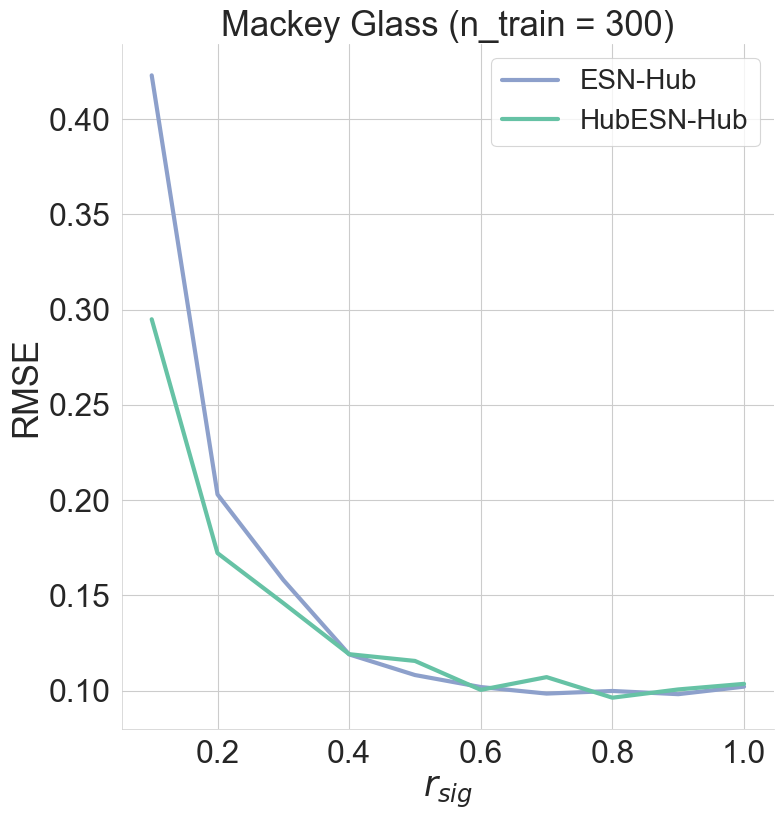

In [19]:
r_sig_list = np.round(np.arange(0.1, 1.1, 0.1), 1)
n_train = 300
mode = 'hub'
EXPTPATH = f'../results/mackey/r_sig_{n_train}_{mode}'
PLTPATH = f'../plots/mackey'
esn_mean, esn_std = [], []
hubesn_mean, hubesn_std = [], []
for rs in r_sig_list:
    esn_rmse = np.load(f'{EXPTPATH}/esn_rmse_{rs}.npy')
    hubesn_rmse = np.load(f'{EXPTPATH}/hubesn_rmse_{rs}.npy')
    esn_mean.append(np.mean(esn_rmse))
    esn_std.append(np.std(esn_rmse))
    hubesn_mean.append(np.mean(hubesn_rmse))
    hubesn_std.append(np.std(hubesn_rmse))
esn_mean, esn_std = np.array(esn_mean), np.array(esn_std)
hubesn_mean, hubesn_std = np.array(hubesn_mean), np.array(hubesn_std)

# plot settings
font_scale = 2.6
plot_error = False
font_size = 20
capsize = 3
lw = 3
esn_color = 2
hubesn_color = 0
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=font_scale)
sns.set_color_codes("bright")
colors = sns.color_palette("Set2")
fig, ax = plt.subplots(figsize=(8, 8))
if plot_error:
    ax.errorbar(r_sig_list, esn_mean, yerr=esn_std, color=colors[esn_color], capsize=capsize, lw=lw)
    ax.errorbar(r_sig_list, hubesn_mean, yerr=hubesn_std, color=colors[hubesn_color], capsize=capsize, lw=lw)
else:
    ax.plot(r_sig_list, esn_mean, color=colors[esn_color], lw=lw)
    ax.plot(r_sig_list, hubesn_mean, color=colors[hubesn_color], lw=lw)
# make legend
ax.plot([], [], color=colors[esn_color], label='ESN-Hub', lw=lw)
ax.plot([], [], color=colors[hubesn_color], label='HubESN-Hub', lw=lw)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
plt.tight_layout()
plt.legend(prop={'size': font_size})
plt.title(f'Mackey Glass (n_train = {n_train})')
plt.xlabel(r'$r_{sig}$')
plt.ylabel('RMSE')
plt.savefig(f'{PLTPATH}/mackey_r_sig_{n_train}_{mode}.png', dpi=300)
plt.show()

In [40]:
params = {
    'lr': 0.5,
    'p2': 0.2,
    'r_sig': 0.1,
    'n_size': 500,
    'spec_rad': 0.9,
    'in_features': 1,
    'in_scale': 1,
    'activation': 'tanh',
    'input_neurons': 'hub',
    'hub_type': 'mix',
    'use_skip': False,
    'verbose': False,
    'lambda_dc': 0.5,
    'lambda_sc': 0.5,
    'exp_coef': 2,
}

task_pm = {
    'n_train': 600,
    'n_test': 2000,
}
task = MackeyGlass(**task_pm)

esn = ESN(**params)
esn.fit(task.X_train, task.y_train)
esn_pred, _ = esn.predict(task.X_test)

hubesn = HubESN(**params)
hubesn.fit(task.X_train, task.y_train)
hubesn_pred, _ = hubesn.predict(task.X_test)

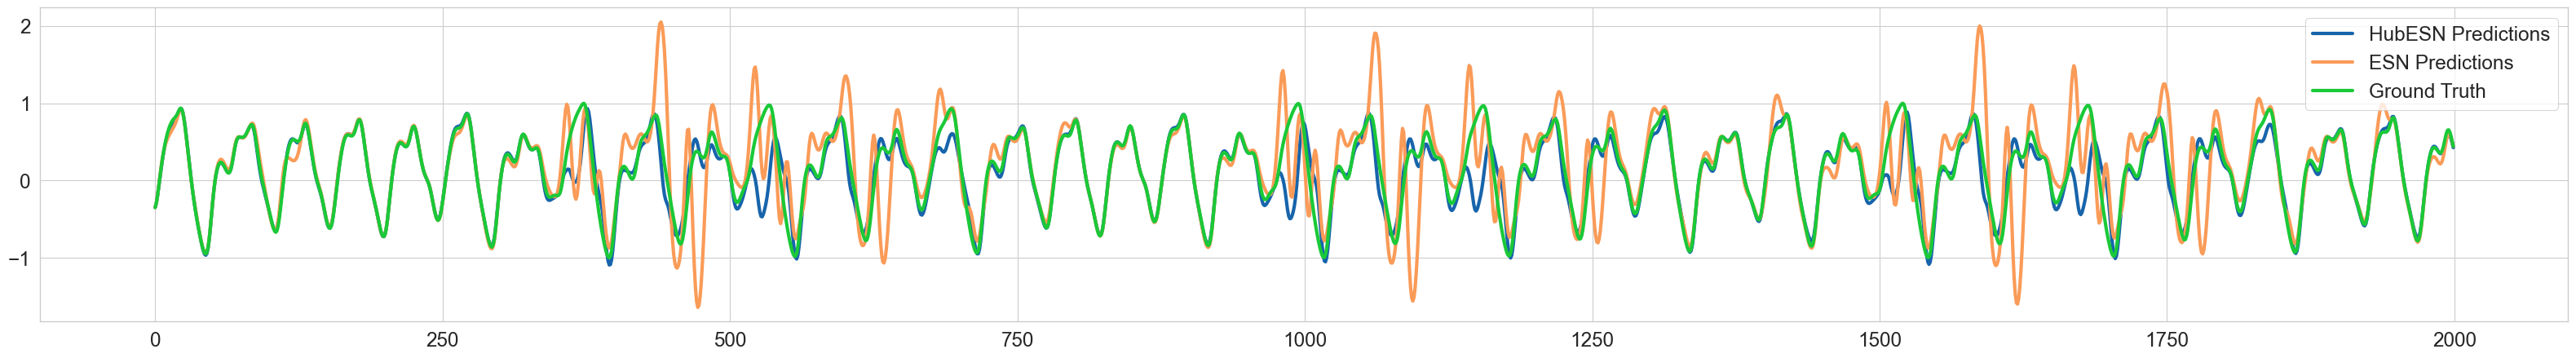

In [47]:
colors = sns.color_palette("RdYlBu", 10)
blues = sns.color_palette("Blues", 4)
lw = 3

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=2)
sns.set_color_codes("bright")

plt.figure(figsize=(40, 5))
plt.plot(hubesn_pred[:2000], label='HubESN Predictions', color=blues[3], lw=lw)
plt.plot(esn_pred[:2000], label='ESN Predictions', color=colors[2], lw=lw)
plt.plot(task.y_test[:2000], label='Ground Truth', color='g', lw=lw)
plt.legend()

In [29]:
params = {
    'lr': 0.5,
    'p2': 0.2,
    'r_sig': 0.1,
    'n_size': 1500,
    'spec_rad': 0.9,
    'in_features': 1,
    'in_scale': 1,
    'activation': 'tanh',
    'input_neurons': 'hub',
    'hub_type': 'mix',
    'use_skip': False,
    'verbose': False,
    'lambda_dc': 0.5,
    'lambda_sc': 0.5,
    'exp_coef': 2,
}

task_pm = {
    'n_train': 4500,
    'n_test': 2000,
}
task = NARMA10(**task_pm)

esn = ESN(**params)
esn.fit(task.X_train, task.y_train)
esn_pred, _ = esn.predict(task.X_test)

hubesn = HubESN(**params)
hubesn.fit(task.X_train, task.y_train)
hubesn_pred, _ = hubesn.predict(task.X_test)

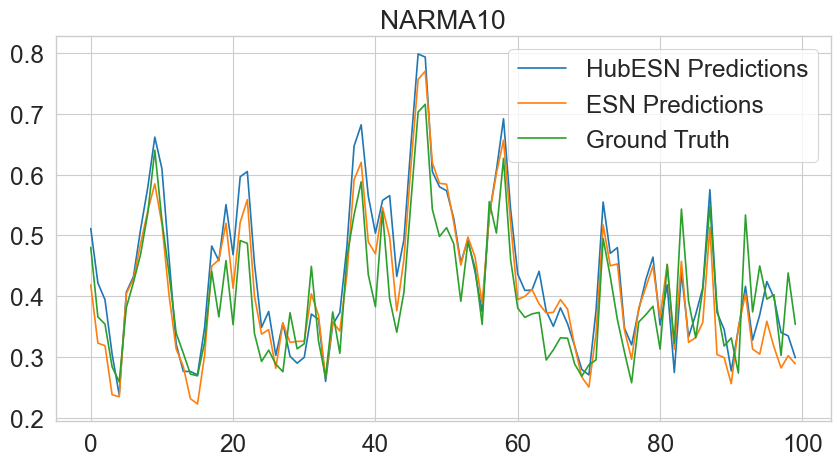

In [30]:
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=2)
sns.set_color_codes("bright")

plt.figure(figsize=(10, 5))
plt.title('NARMA10')
plt.plot(hubesn_pred[200:300], label='HubESN Predictions')
plt.plot(esn_pred[200:300], label='ESN Predictions')
plt.plot(task.y_test[200:300], label='Ground Truth')
plt.legend()